# Super Resolution Convolutional Neural Network (SRCNN)

## Load Dataset

In [ ]:
import os
from google.colab import drive

# Mount Google Drive if needed
drive.mount('/content/drive')

# Set the path to the uploaded .rar file
dataset_path = '/content/drive/MyDrive/CNNMODEL/Dataset.rar'

# Unzip the .rar file using the unrar tool
!apt-get install unrar  # Install unrar if not already installed
!unrar x {dataset_path} /content/  # Extract the contents to /content directory

# Check if dataset is unzipped successfully
os.listdir('/content/')

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/CNNMODEL/Dataset.rar

Creating    /content/Dataset                                          OK
Creating    /content/Dataset/glioma                                   OK
Extracting  /content/Dataset/glioma/0002.jpg                               0%  OK 
Extracting  /content/Dataset/glioma/0003.jpg                               0%  OK 
Extracting  /content/Dataset/glioma/0004.jpg                               0%  OK 
Extracting  /content/Dataset/glioma/0008.jpg                               0%  OK 
Extracting  /content/Dataset/glioma/0012.jpg                               0%  OK 
Extracting  

['.config', 'Dataset', 'drive', 'sample_data']

## Preprocess Dataset


🔁 Processing 700 images from glioma...


100%|██████████| 700/700 [00:01<00:00, 695.36it/s]



🔁 Processing 196 images from healthy...


100%|██████████| 196/196 [00:00<00:00, 493.01it/s]



🔁 Processing 700 images from meningioma...


100%|██████████| 700/700 [00:01<00:00, 507.37it/s]


✅ Preprocessing complete!
Low-Resolution shape: (1596, 256, 256, 1)
High-Resolution shape: (1596, 256, 256, 1)


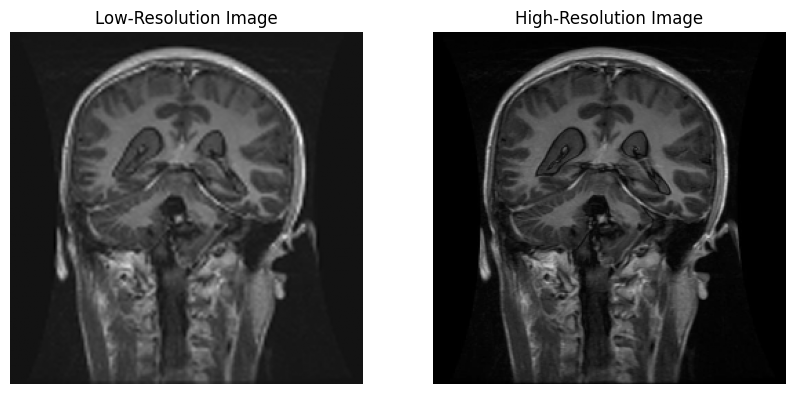

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset path (update this to your dataset location)
dataset_path = "/content/Dataset"  # Adjust this path based on your setup
categories = ["glioma", "healthy", "meningioma"]
target_size = (256, 256)  # Target size for training (256x256)

# Prepare storage for images
X_lr, X_hr = [], []

def preprocess_images():
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        image_paths = sorted(glob(os.path.join(category_path, '*')))
        np.random.shuffle(image_paths)

        print(f"\n🔁 Processing {len(image_paths)} images from {category}...")

        for img_path in tqdm(image_paths):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Resize to HR (256x256) and normalize
                hr_img = cv2.resize(img, target_size).astype('float32') / 255.0  # Normalize to range [0, 1]

                # Generate Low-Resolution image (simulate by downscaling then upscaling)
                lr_img = cv2.resize(hr_img, (target_size[0] // 2, target_size[1] // 2), interpolation=cv2.INTER_CUBIC)
                lr_img = cv2.resize(lr_img, target_size, interpolation=cv2.INTER_CUBIC)

                # Append to lists
                X_lr.append(lr_img[..., np.newaxis])
                X_hr.append(hr_img[..., np.newaxis])

            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")

    return np.array(X_lr), np.array(X_hr)

# Run Preprocessing
X_train_lr, X_train_hr = preprocess_images()
print("✅ Preprocessing complete!")
print("Low-Resolution shape:", X_train_lr.shape)
print("High-Resolution shape:", X_train_hr.shape)

# Optionally, visualize one sample pair (LR vs HR)
index = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_lr[index].squeeze(), cmap='gray')
plt.title("Low-Resolution Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_train_hr[index].squeeze(), cmap='gray')
plt.title("High-Resolution Image")
plt.axis('off')
plt.show()

## Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

# SRCNN Model for 256x256 Images
def build_srcnn_model():
    model = Sequential()

    # First convolutional layer (feature extraction)
    model.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(256, 256, 1)))

    # Second convolutional layer (non-linear mapping)
    model.add(Conv2D(32, (1, 1), activation='relu', padding='same'))

    # Third convolutional layer (reconstruction)
    model.add(Conv2D(1, (5, 5), activation='linear', padding='same'))

    # Compile the model with Adam optimizer and MSE loss
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mean_squared_error', metrics=['accuracy'])

    return model

# Build and summarize the model
srcnn_model = build_srcnn_model()
srcnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Define the folder path in Google Drive
checkpoint_dir = '/content/drive/MyDrive/CNNMODEL'  # Update this to your desired folder in Google Drive

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint file path
checkpoint_filepath = os.path.join(checkpoint_dir, 'srcnn_checkpoint.h5')

# Define ModelCheckpoint callback to save the model after each epoch
# 'overwrite=True' ensures that the model is overwritten with the latest one after each epoch
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    save_weights_only=False,  # Save the whole model (not just the weights)
    save_best_only=False,     # Save after each epoch, not just when the validation loss improves
    save_freq='epoch',        # Save after every epoch
    verbose=1                  # Print a message each time the checkpoint is saved
)

# Build the model (assumed you've already defined it)
srcnn_model = build_srcnn_model()

# Train the model with the ModelCheckpoint callback
history = srcnn_model.fit(
    X_train_lr,
    X_train_hr,
    epochs=50,
    batch_size=8,
    validation_split=0.1,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback to the training process
)

# Optionally, save the final model after training (this is different from the checkpoint saving)
srcnn_model.save('/content/drive/MyDrive/CNNMODEL/srcnn_final_model.h5')


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1722 - loss: 0.0092
Epoch 1: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1722 - loss: 0.0092 - val_accuracy: 0.1398 - val_loss: 4.0612e-04
Epoch 2/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1664 - loss: 5.3303e-04
Epoch 2: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1665 - loss: 5.3236e-04 - val_accuracy: 0.1398 - val_loss: 3.0439e-04
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1697 - loss: 4.1297e-04
Epoch 3: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1697 - loss: 4.1307e-04 - val_accuracy: 0.1398 - val_loss: 2.8964e-04
Epoch 4/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1715 - loss: 4.2127e-04
Epoch 4: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1715 - loss: 4.2120e-04 - val_accuracy: 0.1398 - val_loss: 2.9008e-04
Epoch 5/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1653 - loss: 4.0662e-04
Epoch 5: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1653 - loss: 4.0664e-04 - val_accuracy: 0.1398 - val_loss: 2.7788e-04
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1678 - loss: 3.9615e-04
Epoch 6: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1678 - loss: 3.9621e-04 - val_accuracy: 0.1398 - val_loss: 2.7452e-04
Epoch 7/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1655 - loss: 3.8925e-04
Epoch 7: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1656 - loss: 3.8936e-04 - val_accuracy: 0.1398 - val_loss: 2.7220e-04
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1681 - loss: 3.8792e-04
Epoch 8: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1681 - loss: 3.8799e-04 - val_accuracy: 0.1398 - val_loss: 2.9094e-04
Epoch 9/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1708 - loss: 3.8357e-04
Epoch 9: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1708 - loss: 3.8369e-04 - val_accuracy: 0.1398 - val_loss: 2.6829e-04
Epoch 10/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1702 - loss: 3.7894e-04
Epoch 10: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1702 - loss: 3.7901e-04 - val_accuracy: 0.1398 - val_loss: 2.6635e-04
Epoch 11/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1664 - loss: 3.7829e-04
Epoch 11: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1664 - loss: 3.7834e-04 - val_accuracy: 0.1398 - val_loss: 2.6419e-04
Epoch 12/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1634 - loss: 4.0445e-04
Epoch 12: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1635 - loss: 4.0450e-04 - val_accuracy: 0.1398 - val_loss: 2.7742e-04
Epoch 13/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1718 - loss: 3.7557e-04
Epoch 13: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1718 - loss: 3.7558e-04 - val_accuracy: 0.1398 - val_loss: 2.6663e-04
Epoch 14/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1702 - loss: 3.6147e-04
Epoch 14: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1702 - loss: 3.6152e-04 - val_accuracy: 0.1398 - val_loss: 2.5887e-04
Epoch 15/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1718 - loss: 3.5197e-04
Epoch 15: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1718 - loss: 3.5205e-04 - val_accuracy: 0.1398 - val_loss: 2.5782e-04
Epoch 16/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1643 - loss: 3.6656e-04
Epoch 16: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1644 - loss: 3.6651e-04 - val_accuracy: 0.1398 - val_loss: 2.5496e-04
Epoch 17/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1658 - loss: 3.5106e-04
Epoch 17: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1658 - loss: 3.5110e-04 - val_accuracy: 0.1398 - val_loss: 2.5329e-04
Epoch 18/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1699 - loss: 3.5331e-04
Epoch 18: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1699 - loss: 3.5332e-04 - val_accuracy: 0.1398 - val_loss: 2.5408e-04
Epoch 19/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1729 - loss: 3.4039e-04
Epoch 19: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1729 - loss: 3.4047e-04 - val_accuracy: 0.1398 - val_loss: 2.6308e-04
Epoch 20/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1685 - loss: 3.6997e-04
Epoch 20: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1685 - loss: 3.6983e-04 - val_accuracy: 0.1398 - val_loss: 2.4737e-04
Epoch 21/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1683 - loss: 3.3257e-04
Epoch 21: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1683 - loss: 3.3264e-04 - val_accuracy: 0.1398 - val_loss: 2.4517e-04
Epoch 22/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1658 - loss: 3.4739e-04
Epoch 22: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1658 - loss: 3.4732e-04 - val_accuracy: 0.1398 - val_loss: 2.4321e-04
Epoch 23/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1782 - loss: 3.4388e-04
Epoch 23: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1781 - loss: 3.4393e-04 - val_accuracy: 0.1398 - val_loss: 2.4162e-04
Epoch 24/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1679 - loss: 3.3013e-04
Epoch 24: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1679 - loss: 3.3024e-04 - val_accuracy: 0.1398 - val_loss: 2.4123e-04
Epoch 25/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1632 - loss: 3.3264e-04
Epoch 25: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1633 - loss: 3.3267e-04 - val_accuracy: 0.1398 - val_loss: 2.3844e-04
Epoch 26/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1732 - loss: 3.3381e-04
Epoch 26: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1732 - loss: 3.3380e-04 - val_accuracy: 0.1398 - val_loss: 2.3707e-04
Epoch 27/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1646 - loss: 3.3070e-04
Epoch 27: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1647 - loss: 3.3066e-04 - val_accuracy: 0.1398 - val_loss: 2.4670e-04
Epoch 28/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1671 - loss: 3.3478e-04
Epoch 28: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1671 - loss: 3.3479e-04 - val_accuracy: 0.1398 - val_loss: 2.3433e-04
Epoch 29/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1681 - loss: 3.1964e-04
Epoch 29: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1681 - loss: 3.1970e-04 - val_accuracy: 0.1398 - val_loss: 2.3300e-04
Epoch 30/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1695 - loss: 3.2551e-04
Epoch 30: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1695 - loss: 3.2545e-04 - val_accuracy: 0.1398 - val_loss: 2.3312e-04
Epoch 31/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1696 - loss: 3.1448e-04
Epoch 31: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1695 - loss: 3.1453e-04 - val_accuracy: 0.1398 - val_loss: 2.3179e-04
Epoch 32/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1684 - loss: 3.0555e-04
Epoch 32: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1684 - loss: 3.0576e-04 - val_accuracy: 0.1398 - val_loss: 2.3235e-04
Epoch 33/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1686 - loss: 3.2844e-04
Epoch 33: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1686 - loss: 3.2833e-04 - val_accuracy: 0.1398 - val_loss: 2.5750e-04
Epoch 34/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1654 - loss: 3.4390e-04
Epoch 34: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1655 - loss: 3.4359e-04 - val_accuracy: 0.1398 - val_loss: 2.3580e-04
Epoch 35/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1695 - loss: 3.0305e-04
Epoch 35: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1695 - loss: 3.0312e-04 - val_accuracy: 0.1398 - val_loss: 2.2770e-04
Epoch 36/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1680 - loss: 3.1194e-04
Epoch 36: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1680 - loss: 3.1195e-04 - val_accuracy: 0.1398 - val_loss: 2.2717e-04
Epoch 37/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1753 - loss: 3.1229e-04
Epoch 37: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1752 - loss: 3.1227e-04 - val_accuracy: 0.1398 - val_loss: 2.2667e-04
Epoch 38/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1678 - loss: 3.1826e-04
Epoch 38: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1678 - loss: 3.1824e-04 - val_accuracy: 0.1398 - val_loss: 2.2538e-04
Epoch 39/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1660 - loss: 3.1509e-04
Epoch 39: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1661 - loss: 3.1500e-04 - val_accuracy: 0.1398 - val_loss: 2.2559e-04
Epoch 40/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1701 - loss: 3.2920e-04
Epoch 40: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1701 - loss: 3.2905e-04 - val_accuracy: 0.1398 - val_loss: 2.2438e-04
Epoch 41/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1760 - loss: 3.0971e-04
Epoch 41: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1759 - loss: 3.0970e-04 - val_accuracy: 0.1398 - val_loss: 2.2396e-04
Epoch 42/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1666 - loss: 3.1409e-04
Epoch 42: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1666 - loss: 3.1401e-04 - val_accuracy: 0.1398 - val_loss: 2.2379e-04
Epoch 43/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1640 - loss: 3.1194e-04
Epoch 43: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1641 - loss: 3.1187e-04 - val_accuracy: 0.1398 - val_loss: 2.2314e-04
Epoch 44/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1711 - loss: 3.0434e-04
Epoch 44: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1710 - loss: 3.0435e-04 - val_accuracy: 0.1398 - val_loss: 2.2451e-04
Epoch 45/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1701 - loss: 3.1221e-04
Epoch 45: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1701 - loss: 3.1219e-04 - val_accuracy: 0.1398 - val_loss: 2.2213e-04
Epoch 46/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1666 - loss: 2.9783e-04
Epoch 46: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1666 - loss: 2.9792e-04 - val_accuracy: 0.1398 - val_loss: 2.2129e-04
Epoch 47/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1698 - loss: 3.0243e-04
Epoch 47: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1698 - loss: 3.0246e-04 - val_accuracy: 0.1398 - val_loss: 2.2096e-04
Epoch 48/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1698 - loss: 2.8880e-04
Epoch 48: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1697 - loss: 2.8901e-04 - val_accuracy: 0.1398 - val_loss: 2.2050e-04
Epoch 49/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1785 - loss: 2.8491e-04
Epoch 49: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1784 - loss: 2.8518e-04 - val_accuracy: 0.1398 - val_loss: 2.2040e-04
Epoch 50/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1692 - loss: 2.9968e-04
Epoch 50: saving model to /content/drive/MyDrive/CNNMODEL/srcnn_checkpoint.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1692 - loss: 2.9970e-04 - val_accuracy: 0.1398 - val_loss: 2.2037e-04


## Model Evaluation

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


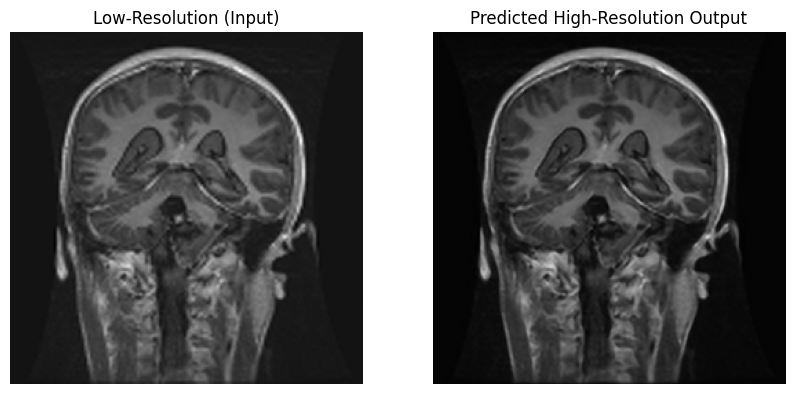

PSNR Value: 35.518720981154964
SSIM Value: 0.96525691741848


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def predict_and_evaluate(srcnn_model, X_lr, X_hr, index=0):
    """
    Predicts High-Resolution (HR) images from Low-Resolution (LR) images using a pre-trained SRCNN model,
    displays the results, and calculates PSNR and SSIM between predicted HR and actual HR.

    Args:
    - srcnn_model (tf.keras.Model): Pre-trained SRCNN model.
    - X_lr (numpy.ndarray): Low-Resolution images.
    - X_hr (numpy.ndarray): High-Resolution images (ground truth).
    - index (int): Index of the image to visualize.

    Returns:
    - None (prints PSNR and SSIM values)
    """
    # Generate predictions on LR images
    predicted_hr_image = srcnn_model.predict(X_lr)

    # Display the results: First LR image and its corresponding predicted HR
    plt.figure(figsize=(10, 5))

    # Low-Resolution Image
    plt.subplot(1, 2, 1)
    plt.imshow(X_lr[index].squeeze(), cmap='gray')
    plt.title("Low-Resolution (Input)")
    plt.axis('off')

    # Predicted High-Resolution Image
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_hr_image[index].squeeze(), cmap='gray')
    plt.title("Predicted High-Resolution Output")
    plt.axis('off')

    plt.show()

    # Optionally: Compare PSNR/SSIM of predicted HR vs actual HR
    # Calculate PSNR (Peak Signal-to-Noise Ratio)
    psnr_value = psnr(X_hr[index].squeeze(), predicted_hr_image[index].squeeze())
    print(f"PSNR Value: {psnr_value}")

    # Calculate SSIM (Structural Similarity Index)
    # Since images are normalized to [0, 1], set data_range=1.0
    ssim_value = ssim(X_hr[index].squeeze(), predicted_hr_image[index].squeeze(), data_range=1.0)
    print(f"SSIM Value: {ssim_value}")

# Example usage:

# Load the pre-trained SRCNN model (adjust the path if needed)
srcnn_model = tf.keras.models.load_model('/content/drive/MyDrive/CNNMODEL/srcnn_final_model.h5')

# Call the prediction function on the test data
# Assuming X_train_lr (Low-Resolution) and X_train_hr (High-Resolution) are available
predict_and_evaluate(srcnn_model, X_train_lr, X_train_hr, index=0)